In [1]:
# choose specific GPU to run notebook parallel to others
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
from tensorflow import keras
from keras import layers
from PIL import Image
from natsort import natsorted
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import KFold
from random import randrange

import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import re as regex
import os
import pathlib
import itertools
import sys

print(tf.__version__)

2024-12-18 15:23:17.370868: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-18 15:23:18.337789: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-12-18 15:23:18.337896: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-12-18 15:23:18.337908: W tensorfl

2.11.1


In [3]:
tf.keras.__version__

'2.11.0'

In [4]:
DS_CACHE = "../datasets/cache/"

In [5]:
def clear_ds_cache(prefix=""):
    for ds_path in pathlib.Path(DS_CACHE).glob(prefix + "*"):
        os.remove(ds_path)

In [6]:
clear_ds_cache(prefix='px')

# Load multi spectral scenes

In [7]:
UV_FILTER = ["nofilter"]    
SWIR_FILTER = ["nofilter","1000nm","1300nm","1450nm", "1550nm"]
VIS_FILTER = ["nofilter_r", "nofilter_g", "nofilter_b"]
VIS_NIR_FILTER = ["nofilter", "740nm","845nm","880nm", "940nm"]
SPECTRUM = ["VIS_[0-5][0-9]", "VIS_NIR", "SWIR", "UV"]

uv_filter_regex = list(map(regex.compile, UV_FILTER))
swir_filter_regex = list(map(regex.compile, SWIR_FILTER))
vis_filter_regex = list(map(regex.compile, VIS_FILTER))
vis_nir_filter_regex = list(map(regex.compile, VIS_NIR_FILTER))
spectrum_regex = list(map(regex.compile, SPECTRUM))

In [8]:
# sorting the image paths for one multi sepctral scene
def sort_channel_paths(channel_paths):
    sorted_path_list = [None] * 14
    mask = None
#    print(len(sorted_path_list))
    for cp in channel_paths:
        if cp.split('/')[-2] == 'masks':
            mask = cp
        
        else:
            channel_name = cp.split('/')[-1]
            if spectrum_regex[0].search(channel_name):
                if vis_filter_regex[0].search(channel_name):
                    sorted_path_list[0] = cp
                elif vis_filter_regex[1].search(channel_name):
                    sorted_path_list[1] = cp
                elif vis_filter_regex[2].search(channel_name):
                    sorted_path_list[2] = cp
                else:
                    print(channel_name, 'VIS filter not found')
                    sys.exit()
                    
            elif spectrum_regex[1].search(channel_name):
                if vis_nir_filter_regex[0].search(channel_name):
                    sorted_path_list[3] = cp
                elif vis_nir_filter_regex[1].search(channel_name):
                    sorted_path_list[4] = cp
                elif vis_nir_filter_regex[2].search(channel_name):
                    sorted_path_list[5] = cp
                elif vis_nir_filter_regex[3].search(channel_name):
                    sorted_path_list[6] = cp
                elif vis_nir_filter_regex[4].search(channel_name):
                    sorted_path_list[7] = cp
                else:
                    print(cp, 'VIS_NIR filter not found')
                    sys.exit()
            
            elif spectrum_regex[2].search(channel_name):
                 if swir_filter_regex[0].search(channel_name):
                     sorted_path_list[8] = cp 
                 elif swir_filter_regex[1].search(channel_name):
                     sorted_path_list[9] = cp
                 elif swir_filter_regex[2].search(channel_name):
                     sorted_path_list[10] = cp
                 elif swir_filter_regex[3].search(channel_name):
                     sorted_path_list[11] = cp
                 elif swir_filter_regex[4].search(channel_name):
                     sorted_path_list[12] = cp
                 else:
                    print(cp, 'SWIR filter not found')
                    sys.exit()

            elif spectrum_regex[3].search(channel_name):
                if uv_filter_regex[0].search(channel_name):
                    sorted_path_list[13] = cp
                else:
                    print(cp, 'UV filter not found')
                    sys.exit()
        
            
            else:
                print(cp, 'spectrum not found')
                sys.exit()
    
    if mask is None:
        print('MSI of', channel_paths[0], 'contains no mask')
        sys.exit()
    if None in sorted_path_list:
        print('MSI of', channel_paths[0], 'does not contain all channels')
        sys.exit()
    return sorted_path_list, mask

In [9]:
# load one image of an multi spectral scene as tensor
def imgpath_to_tensor(path, channels=1):
    img_file = tf.io.read_file(path)
    img = tf.io.decode_png(
        contents = img_file,
        channels = channels,
        dtype = tf.dtypes.uint8,
    )
    
    return img


In [10]:
# mapping numeric labels, pixel values and alphabetic labels for MaterialID.md
NUMERIC_CLASS_LABELS= [-1, 0, 10, 11, 20, 21, 30, 31, 60, 61, 40, 41, 50, 51, 70, 71,\
                      80, 81, 90, 91, 110, 111]
WRITTEN_CLASS_LABELS = ['nicht gelabled', 'unbekannt',\
                        'vermutlich Vermischtes', 'sehr wahrscheinlich Vermischtes',\
                        'vermutlich Plastik', 'sehr wahrscheinlich Plastik',\
                        'vermutlich Pappe', 'sehr wahrscheinlich Pappe',\
                        'vermutlich Textilen', 'sehr wahrscheinlich Textilien',\
                        'vermutlich Holz', 'sehr wahrscheinlich Holz',\
                        'vermutlich Metall', 'sehr wahrscheinlich Metall',\
                        'vermutlich Schaumstoff', 'sehr wahrscheinlich Schaumstoff',\
                        'vermutlich Mineralstoff', 'sehr wahrscheinlich Mineralstoff',\
                        'vermutlich Batterien', 'sehr wahrscheinlich Batterien',\
                        'vermutlich Hintergrund', 'sehr wahrscheinlich Hintergrund'\
]
WRITTEN_AND_NUMERIC_LABELS = list(zip(NUMERIC_CLASS_LABELS, WRITTEN_CLASS_LABELS))
print(*WRITTEN_AND_NUMERIC_LABELS, sep='\n')

(-1, 'nicht gelabled')
(0, 'unbekannt')
(10, 'vermutlich Vermischtes')
(11, 'sehr wahrscheinlich Vermischtes')
(20, 'vermutlich Plastik')
(21, 'sehr wahrscheinlich Plastik')
(30, 'vermutlich Pappe')
(31, 'sehr wahrscheinlich Pappe')
(60, 'vermutlich Textilen')
(61, 'sehr wahrscheinlich Textilien')
(40, 'vermutlich Holz')
(41, 'sehr wahrscheinlich Holz')
(50, 'vermutlich Metall')
(51, 'sehr wahrscheinlich Metall')
(70, 'vermutlich Schaumstoff')
(71, 'sehr wahrscheinlich Schaumstoff')
(80, 'vermutlich Mineralstoff')
(81, 'sehr wahrscheinlich Mineralstoff')
(90, 'vermutlich Batterien')
(91, 'sehr wahrscheinlich Batterien')
(110, 'vermutlich Hintergrund')
(111, 'sehr wahrscheinlich Hintergrund')


In [11]:
def print_label_stats(ds_version):# get all existing classes
    
    path = []
    path = [list(pathlib.Path(scene).glob('registered_scene/masks/*.png'))[0] for scene in ds_version]
    path = [str(p) for p in path]
    masks_t = path
    masks_t = list(map(imgpath_to_tensor, masks_t))
    masks_t = [tf.reshape(mask, [-1]) for mask in masks_t]
    masks_t = tf.concat(masks_t, axis=-1)

    existing_labels, idx = tf.unique(masks_t)
    existing_labels = sorted(existing_labels.numpy().tolist())
    print("existing labels", existing_labels)

    used_labels =  existing_labels[1:]
    print("used_labls", used_labels)

    print()
    label, _, count = tf.unique_with_counts(masks_t)
    print("counting labels", sorted(list(zip(label.numpy().tolist(), count.numpy().tolist()))))

    print()
    print(*WRITTEN_AND_NUMERIC_LABELS, sep='\n')

In [12]:
# Schaumstoff is ignored
used_labels = [21, 31, 41, 51, 61, 71, 81]
used_labels_written = ['plasitc', 'paper', 'wood', 'metal', 'textiles', 'foam', 'minerals']

In [13]:
class PxDatasetBuilder():
    
    def __init__(self, msi_dirs, balance, labels, batch_size, cache_name):
        self.msi_dirs = msi_dirs
        self.balanced = balance
        self.labels = labels
        self.cache_name = cache_name
        self.batch_size = batch_size
    
    def __load_pixels__(self):
        
        if(type(self.msi_dirs[0] == str)):
            self.msi_dirs = [pathlib.Path(p) for p in self.msi_dirs]
        
    
        for msi_d in self.msi_dirs:
            channel_paths, mask_path = sort_channel_paths([str(p) for p in msi_d.glob('registered_scene/*/*.png')])
            msi_as_list_of_tensors = list(map(imgpath_to_tensor, channel_paths))
            msi_as_tensor =  tf.concat(msi_as_list_of_tensors, axis=-1)

            img_patches = tf.reshape(msi_as_tensor, [-1, 14])

            mask_as_tensor = imgpath_to_tensor(mask_path, channels=1)
            mask_patches = tf.reshape(mask_as_tensor, [-1, 1])
            
            #remove background
            indices = tf.where(tf.not_equal(tf.squeeze(mask_patches), tf.constant(0, dtype=tf.uint8)))

            indices = tf.squeeze(indices)

            materials = tf.gather(mask_patches, indices=indices)
            materials = tf.squeeze(materials)
            
            pixel_values = tf.gather(img_patches, indices=indices)

            yield pixel_values, materials

    
    def __create_base_dataset__(self):
        # pull data
        data = list(itertools.islice(self.__load_pixels__(),len(self.msi_dirs)))
        
        x= []
        y = []
        
        for pixels, labels in data:
            x.append(pixels)
            y.append(labels)
        
        x = tf.concat(x, axis=0)
        y = tf.concat(y, axis=0)
        
        base_ds = tf.data.Dataset.from_tensor_slices((x, y))\
                    .shuffle(buffer_size=len(x))\
                    .map(lambda x, y : \
                         (x, tf.squeeze(tf.cast(tf.where(tf.equal(y, used_labels)), dtype=tf.uint8), axis=0))\
                    )\
                    .take(len(x))
        if self.balanced:
            base_ds = base_ds.cache(DS_CACHE + self.cache_name + "-base-ds")                    
        
        return base_ds, len(x)
    
    
    def __balance_ds__(self, ds):
        
        label_count = [0] * len(used_labels)
        ds = ds.batch(64000)
        
        for x, y in ds:
            y, _, count = tf.unique_with_counts(tf.squeeze(y))
            for l, index in zip(y, range(len(y))):
                label_count[l] += count[index].numpy()
        
        ds_per_label = []
        for i in range(len(used_labels)):
            ds_per_label.append(
                 ds.unbatch().filter(lambda x,y: y[0] == i)\
                .shuffle(buffer_size=label_count[i])\
                .take(min(label_count))
            )
        
        bal_ds = ds_per_label[0]
        for ds in ds_per_label[1:]:
            bal_ds = bal_ds.concatenate(ds)
        
        return bal_ds, len(label_count) * min(label_count)

        
    def get_dataset(self):
        base_ds, ds_length = self.__create_base_dataset__()

        if not self.balanced:
            return   base_ds\
                    .batch(self.batch_size)\
                    .cache(DS_CACHE + self.cache_name)\
                    .prefetch(tf.data.AUTOTUNE)
        else:
            balanced_ds, bal_ds_len = self.__balance_ds__(base_ds)
            return balanced_ds.shuffle(buffer_size=bal_ds_len)\
                    .batch(self.batch_size)\
                    .cache(DS_CACHE + self.cache_name + "-bal")\
                    .prefetch(tf.data.AUTOTUNE)
        

In [14]:
def save_best_model(name, init_threshold):
    
    return keras.callbacks.ModelCheckpoint(
        'models/' + name,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
        mode="auto",
        save_freq="epoch",
        initial_value_threshold=init_threshold,
    )

In [15]:
class RepetitiveTrainer():
    def __init__(self, model_func, iterations, epochs=200, save_model_name="", es_patience=10, es_start=0, cw=None):
        self.model_func = model_func
        self.iterations = iterations
        self.epochs = epochs
        self.early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=es_patience, start_from_epoch=es_start)
        self.histories = []
        self.save_model_name = save_model_name
        self.cw = cw
    
    
    def __plot_history__(self,index):
        history = self.histories[index]
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']

        loss = history.history['loss']
        val_loss = history.history['val_loss']

        plt.figure(figsize=(8, 8))
        plt.subplot(2, 1, 1)
        plt.plot(acc, label='Training Accuracy')
        plt.plot(val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.ylabel('Accuracy')
        plt.ylim([min(plt.ylim()),1])
        plt.title('Training and Validation Accuracy')

        plt.subplot(2, 1, 2)
        plt.plot(loss, label='Training Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.ylabel('Cross Entropy')
        plt.ylim([0,1.0])
        plt.title('Training and Validation Loss')
        plt.xlabel('epoch')
        plt.show()

        max_val = max(val_acc)
        max_val_index = np.argmax(val_acc)
        train_on_max_val = acc[max_val_index]
        max_val_epoch = max_val_index + 1

        print(f'highest validation accuracy {max_val * 100:.2f}')
        print(f'with train accuracy {train_on_max_val * 100:.2f}')
        print('on epoch', max_val_epoch)

    
    def train(self, train_ds, val_ds, ds_name):
        min_val_acc = 0.50
        callbacks = [self.early_stopping]
        print(self.cw)
        for it in range(self.iterations):
            if self.save_model_name != "":
                smc = save_best_model(name=self.save_model_name + "_"+ds_name, init_threshold=min_val_acc)
                callbacks = [self.early_stopping, smc]
            new_model = self.model_func()
            hist = new_model.fit(train_ds, epochs=self.epochs,
                validation_data=val_ds, 
                      callbacks=callbacks, 
                      shuffle=False, class_weight=self.cw
            )
            min_val_acc = max(max(hist.history['val_accuracy']), min_val_acc)
            self.histories.append(hist)
            print("-------------------NEXT ITERATION--------------------")
    
    
    def show_results(self, indices=None):
        history = self.histories
        if indices:
            history = history[indices[0]:indices[1]]
            
        max_val_accs = [round(max(hist.history['val_accuracy'] * 10),2) for hist in history]
        max_val_per_iteration = list(zip(range(len(max_val_accs)), max_val_accs))
        print("max val_acc per iteration:",  max_val_per_iteration)
        print("highest val_acc:", max(max_val_accs))
        print("mean max:", tf.math.reduce_mean(max_val_accs, axis=0), \
              "std_dev:", tf.math.reduce_std(max_val_accs, axis=0))
        self.__plot_history__(indices[0] + max_val_accs.index(max(max_val_accs)))
    

In [16]:
class ManualSplitTrainer():
    def __init__(self, train_test_pairs, ds_builder, ds_names = []):
        self.train_test_pairs = train_test_pairs
        self.ds_builder = ds_builder
        self.datasets = []
        self.repetitions = len(train_test_pairs)
        if len(ds_names) > 0:
            self.ds_names = ds_names
        else:
            self.ds_names = [""] * len(train_test_pairs)
        self.__build__datasets__()
        
    def __build__datasets__(self):
        clear_ds_cache(prefix="px")
        self.datasets = []
        for i, (train_dirs, test_dirs) in enumerate(self.train_test_pairs):
    
            train_ds = self.ds_builder(train_dirs, balance=False,\
                                       labels=used_labels, batch_size=32786,\
                                       cache_name="px-train-" + str(i)\
                                       ).get_dataset()
            
            test_ds = self.ds_builder(test_dirs, balance=False,\
                                     labels=used_labels, batch_size=32786,
                                     cache_name="px-test" + str(i)\
                                     ).get_dataset()
            
            self.datasets.append((train_ds, test_ds))
    
    def train(self, trainer):
        for i, (train_ds, test_ds) in enumerate(self.datasets):
            print('#################################')
            print('          Split ',i)
            print('#################################')

            trainer.train(train_ds, test_ds, ds_name = self.ds_names[i])
    
    
    def show_results(self, trainer):    
        its=trainer.iterations
        for s in range(len(self.train_test_pairs)):
            print("--------Results for split", s, "---------------")
            indices = (s * its, s * its + its)
            trainer.show_results(indices)

In [17]:
MSIv5_BASE_PATH = "../datasets/MSIv5/UV_VIS_SWIR/"

In [18]:
skipp_msiv5_darkroom = [
    #chessboard only
    "24_03_14_darkroom/recording/24_03_14_13_16_40",
    # to much textiles
    "24_03_14_darkroom/recording/24_03_14_16_21_25",
    "24_03_14_darkroom/recording/24_03_14_16_42_23",
    "24_03_14_darkroom/recording/24_03_14_16_46_10",
    "24_03_14_darkroom/recording/24_03_14_17_00_26",
    "24_03_14_darkroom/recording/24_03_14_17_29_41",
    "24_03_14_darkroom/recording/24_03_14_17_37_00",
    "24_03_14_darkroom/recording/24_03_14_17_46_08",
    "24_03_14_darkroom/recording/24_03_14_17_49_23",
    "24_03_14_darkroom/recording/24_03_14_17_58_14",
    "24_03_14_darkroom/recording/24_03_14_18_01_26",
    "24_03_14_darkroom/recording/24_03_14_18_05_06",
    "24_03_14_darkroom/recording/24_03_14_18_09_13"
]
skipp_msiv5_darkroom = [ MSIv5_BASE_PATH + p for p in skipp_msiv5_darkroom]

val_msiv5_darkroom = [
    # all object are in train
    "24_03_14_darkroom/recording/24_03_14_14_04_06",
    
    # most objects seem to be in train
    "24_03_14_darkroom/recording/24_03_14_14_24_11",
    "24_03_14_darkroom/recording/24_03_14_17_21_44"
]
val_msiv5_darkroom = [MSIv5_BASE_PATH + p for p in val_msiv5_darkroom]

train_msiv5_darkroom =[str(p) for p in pathlib.Path( MSIv5_BASE_PATH + "24_03_14_darkroom").glob('recording/*/')
                      if p.is_dir()] 
train_msiv5_darkroom = [p for p in train_msiv5_darkroom if p not in skipp_msiv5_darkroom + val_msiv5_darkroom]


In [19]:
train_msiv5_darkroom

['../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_14_17_09',
 '../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_14_35_37',
 '../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_17_25_29',
 '../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_17_55_54',
 '../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_17_08_23',
 '../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_16_14_21',
 '../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_17_03_55',
 '../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_13_50_36',
 '../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_16_26_27',
 '../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_17_52_24',
 '../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_17_16_33',
 '../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_17_40_17',
 '../datasets/MSIv5/UV_VIS_SWIR/24_03_14

In [20]:
print(len(train_msiv5_darkroom), len(val_msiv5_darkroom))

14 3


In [21]:
print_label_stats(train_msiv5_darkroom)

2024-12-18 15:23:20.099510: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-18 15:23:20.354097: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 23786 MB memory:  -> device: 0, name: Quadro P6000, pci bus id: 0000:04:00.0, compute capability: 6.1


existing labels [0, 21, 31, 41, 51, 61, 81]
used_labls [21, 31, 41, 51, 61, 81]

counting labels [(0, 34461550), (21, 916905), (31, 955337), (41, 749144), (51, 1156379), (61, 3157055), (81, 489908)]

(-1, 'nicht gelabled')
(0, 'unbekannt')
(10, 'vermutlich Vermischtes')
(11, 'sehr wahrscheinlich Vermischtes')
(20, 'vermutlich Plastik')
(21, 'sehr wahrscheinlich Plastik')
(30, 'vermutlich Pappe')
(31, 'sehr wahrscheinlich Pappe')
(60, 'vermutlich Textilen')
(61, 'sehr wahrscheinlich Textilien')
(40, 'vermutlich Holz')
(41, 'sehr wahrscheinlich Holz')
(50, 'vermutlich Metall')
(51, 'sehr wahrscheinlich Metall')
(70, 'vermutlich Schaumstoff')
(71, 'sehr wahrscheinlich Schaumstoff')
(80, 'vermutlich Mineralstoff')
(81, 'sehr wahrscheinlich Mineralstoff')
(90, 'vermutlich Batterien')
(91, 'sehr wahrscheinlich Batterien')
(110, 'vermutlich Hintergrund')
(111, 'sehr wahrscheinlich Hintergrund')


In [22]:
print_label_stats(val_msiv5_darkroom)

existing labels [0, 21, 31, 41, 51, 61, 81]
used_labls [21, 31, 41, 51, 61, 81]

counting labels [(0, 7961475), (21, 274516), (31, 213772), (41, 240344), (51, 115986), (61, 74411), (81, 95127)]

(-1, 'nicht gelabled')
(0, 'unbekannt')
(10, 'vermutlich Vermischtes')
(11, 'sehr wahrscheinlich Vermischtes')
(20, 'vermutlich Plastik')
(21, 'sehr wahrscheinlich Plastik')
(30, 'vermutlich Pappe')
(31, 'sehr wahrscheinlich Pappe')
(60, 'vermutlich Textilen')
(61, 'sehr wahrscheinlich Textilien')
(40, 'vermutlich Holz')
(41, 'sehr wahrscheinlich Holz')
(50, 'vermutlich Metall')
(51, 'sehr wahrscheinlich Metall')
(70, 'vermutlich Schaumstoff')
(71, 'sehr wahrscheinlich Schaumstoff')
(80, 'vermutlich Mineralstoff')
(81, 'sehr wahrscheinlich Mineralstoff')
(90, 'vermutlich Batterien')
(91, 'sehr wahrscheinlich Batterien')
(110, 'vermutlich Hintergrund')
(111, 'sehr wahrscheinlich Hintergrund')


In [23]:
print(val_msiv5_darkroom[0])
print(skipp_msiv5_darkroom[0])
print(train_msiv5_darkroom[0])

../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_14_04_06
../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_13_16_40
../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_14_17_09


In [24]:
n_classes = len(used_labels)

# Pixel Classification Models

In [25]:
def create_mlp():
    mlp_pn = tf.keras.Sequential()
    mlp_pn.add(layers.Rescaling(1./255,  input_shape=(14,)))
    mlp_pn.add(layers.Dense(512, activation='relu'))
    mlp_pn.add(layers.Dense(256, activation='relu'))
    mlp_pn.add(layers.Dense(128, activation='relu'))
    mlp_pn.add(layers.Dense(64, activation='relu'))
    mlp_pn.add(layers.Dense(32, activation='relu'))
    mlp_pn.add(layers.Dense(n_classes, activation='softmax'))
    
    mlp_pn.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    return mlp_pn


create_mlp().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 14)                0         
                                                                 
 dense (Dense)               (None, 512)               7680      
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 7)                 2

In [26]:
def create_spectral_conv():
    i = keras.Input((14))
    x = tf.expand_dims(i, axis=1) # shape (None, 1, 14)
    x = tf.expand_dims(x, axis=1) # shape (None, 1, 1, 14)
    x = tf.expand_dims(x, axis=-1) # shape (None, 1, 1, 1, 14)
    
    #x = keras.layers.Conv3D(128, (1,1,14), activation='relu', padding='same')(x)
    
    x = keras.layers.Conv3D(128, (1,1,3), activation='relu', padding='same')(x)
    #x = keras.layers.Conv3D(128, (1,1,3), activation='relu', padding='same')(x)

    x = layers.MaxPooling3D(pool_size=(1, 1, 2), padding='same')(x)
    x = keras.layers.Conv3D(128, (1,1,3), activation='relu', padding='same')(x)
    #x = keras.layers.Conv3D(128, (1,1,3), activation='relu', padding='same')(x)

    x = layers.MaxPooling3D(pool_size=(1, 1, 2), padding='same')(x)

    x = keras.layers.Conv3D(256, (1,1,3), activation='relu', padding='same')(x)
    x = layers.GlobalMaxPooling3D()(x)
    
    x = layers.Flatten()(x)
    out = keras.layers.Dense(len(used_labels), activation='softmax')(x)
    
    mlp_3dconv = keras.Model(inputs=i, outputs=out)
    #optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    #mlp_3dconv.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    mlp_3dconv.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    return mlp_3dconv

create_spectral_conv().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14)]              0         
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 1, 14)            0         
                                                                 
 tf.expand_dims_1 (TFOpLambd  (None, 1, 1, 14)         0         
 a)                                                              
                                                                 
 tf.expand_dims_2 (TFOpLambd  (None, 1, 1, 14, 1)      0         
 a)                                                              
                                                                 
 conv3d (Conv3D)             (None, 1, 1, 14, 128)     512       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 1, 1, 7, 128)     0     

In [27]:
man_train = ManualSplitTrainer(train_test_pairs=[
                                                    (train_msiv5_darkroom, val_msiv5_darkroom)
                                                ],
                               ds_names=["msi_v5_darkroom"],
                               ds_builder=PxDatasetBuilder)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


# calculate class weigths

In [28]:
labels = []

for msi, lbl in man_train.datasets[0][0]:
    labels.append(tf.reshape(lbl, [-1]))

labels = tf.concat(labels, axis=0)
labels = tf.cast(labels, tf.dtypes.float64)

print(labels.shape)
print(labels[1])

classes, _ = tf.unique(labels)
classes = sorted(tf.cast(classes, tf.dtypes.float64).numpy().tolist())
print(classes)

weights = compute_class_weight('balanced', classes=classes, y=labels.numpy())
print(weights)

class_weights = {}

for c,w in zip(classes, weights):
    class_weights[int(c)] = w

print(class_weights)

#add foam (doesn't occure)
class_weights[5] = 0.0
class_weights = dict(sorted(class_weights.items()))
print(class_weights)

2024-12-18 15:23:38.461415: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7012517 of 7424728
2024-12-18 15:23:39.045854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2024-12-18 15:24:58.231492: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(7424728,)
tf.Tensor(3.0, shape=(), dtype=float64)
[0.0, 1.0, 2.0, 3.0, 4.0, 6.0]
[1.34959965 1.29530696 1.65182484 1.07011167 0.39196487 2.52589194]
{0: 1.3495996495456635, 1: 1.2953069614875867, 2: 1.6518248383043403, 3: 1.0701116733066465, 4: 0.3919648744373052, 6: 2.5258919361730503}
{0: 1.3495996495456635, 1: 1.2953069614875867, 2: 1.6518248383043403, 3: 1.0701116733066465, 4: 0.3919648744373052, 5: 0.0, 6: 2.5258919361730503}


In [29]:
mlp_trainer = RepetitiveTrainer(create_mlp, iterations=10, es_start=40, save_model_name='mlp', cw=class_weights)

In [30]:
man_train.train(mlp_trainer)

#################################
          Split  0
#################################
{0: 1.3495996495456635, 1: 1.2953069614875867, 2: 1.6518248383043403, 3: 1.0701116733066465, 4: 0.3919648744373052, 5: 0.0, 6: 2.5258919361730503}
Epoch 1/200


2024-12-18 15:25:17.193214: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f758108f140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-18 15:25:17.193283: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Quadro P6000, Compute Capability 6.1
2024-12-18 15:25:17.200865: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-18 15:25:17.361707: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


226/227 [============================>.] - ETA: 0s - loss: 1.3170 - accuracy: 0.5329

2024-12-18 15:25:21.354962: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


227/227 [==============================] - 18s 67ms/step - loss: 1.3165 - accuracy: 0.5330 - val_loss: 1.4503 - val_accuracy: 0.4394
Epoch 2/200
 11/227 [>.............................] - ETA: 2s - loss: 1.0518 - accuracy: 0.6029

2024-12-18 15:25:33.771943: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


227/227 [==============================] - 3s 13ms/step - loss: 0.9591 - accuracy: 0.6333 - val_loss: 1.3628 - val_accuracy: 0.5115
Epoch 3/200
227/227 [==============================] - 3s 12ms/step - loss: 0.8068 - accuracy: 0.6875 - val_loss: 1.4081 - val_accuracy: 0.5338
Epoch 4/200
227/227 [==============================] - 3s 12ms/step - loss: 0.6990 - accuracy: 0.7237 - val_loss: 1.4178 - val_accuracy: 0.5380
Epoch 5/200
227/227 [==============================] - 3s 12ms/step - loss: 0.6112 - accuracy: 0.7602 - val_loss: 1.4874 - val_accuracy: 0.5467
Epoch 6/200
227/227 [==============================] - 3s 12ms/step - loss: 0.5554 - accuracy: 0.7861 - val_loss: 1.5394 - val_accuracy: 0.5288
Epoch 7/200
227/227 [==============================] - 3s 12ms/step - loss: 0.5065 - accuracy: 0.8073 - val_loss: 1.5381 - val_accuracy: 0.5299
Epoch 8/200
227/227 [==============================] - 3s 12ms/step - loss: 0.4701 - accuracy: 0.8220 - val_loss: 1.5533 - val_accuracy: 0.5146
Epoc

--------Results for split 0 ---------------
max val_acc per iteration: [(0, 0.55), (1, 0.55), (2, 0.55), (3, 0.56), (4, 0.51), (5, 0.56), (6, 0.57), (7, 0.55), (8, 0.54), (9, 0.55)]
highest val_acc: 0.57
mean max: tf.Tensor(0.549, shape=(), dtype=float32) std_dev: tf.Tensor(0.015132747, shape=(), dtype=float32)


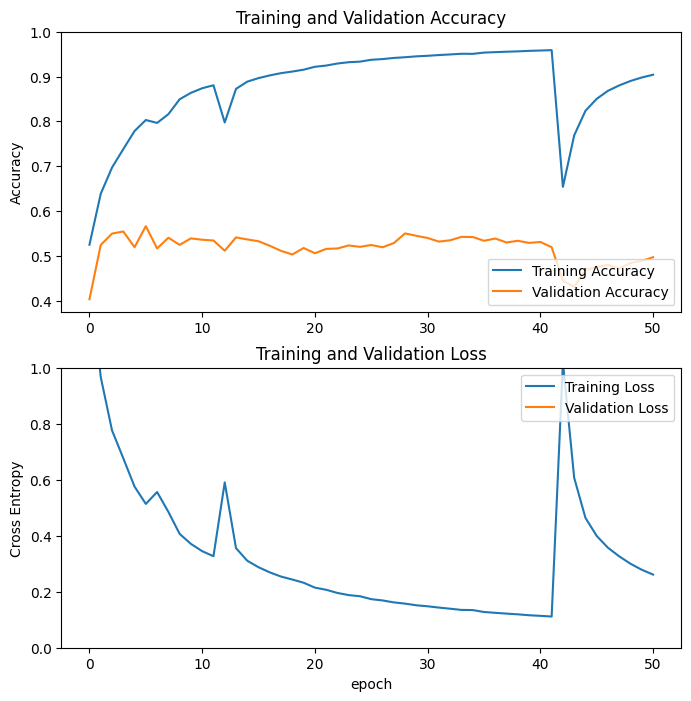

highest validation accuracy 56.60
with train accuracy 80.29
on epoch 6


In [31]:
man_train.show_results(mlp_trainer)

In [32]:
spectral_conv_trainer = RepetitiveTrainer(create_spectral_conv, iterations=10,\
                                          es_start=40 ,save_model_name='spectral_conv', cw=class_weights)

In [33]:
man_train.train(spectral_conv_trainer)

#################################
          Split  0
#################################
{0: 1.3495996495456635, 1: 1.2953069614875867, 2: 1.6518248383043403, 3: 1.0701116733066465, 4: 0.3919648744373052, 5: 0.0, 6: 2.5258919361730503}
Epoch 1/200


2024-12-18 15:51:19.613546: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600


227/227 [==============================] - 31s 126ms/step - loss: 2.1187 - accuracy: 0.5776 - val_loss: 1.3400 - val_accuracy: 0.5097
Epoch 2/200
227/227 [==============================] - 28s 124ms/step - loss: 0.5676 - accuracy: 0.7977 - val_loss: 1.4025 - val_accuracy: 0.5381
Epoch 3/200
227/227 [==============================] - 28s 124ms/step - loss: 0.4242 - accuracy: 0.8494 - val_loss: 1.4751 - val_accuracy: 0.5602
Epoch 4/200
227/227 [==============================] - 28s 124ms/step - loss: 0.3498 - accuracy: 0.8762 - val_loss: 1.5875 - val_accuracy: 0.5522
Epoch 5/200
227/227 [==============================] - 28s 124ms/step - loss: 0.3074 - accuracy: 0.8908 - val_loss: 1.6771 - val_accuracy: 0.5464
Epoch 6/200
227/227 [==============================] - 28s 124ms/step - loss: 0.2773 - accuracy: 0.9011 - val_loss: 1.6632 - val_accuracy: 0.5433
Epoch 7/200
227/227 [==============================] - 28s 124ms/step - loss: 0.2548 - accuracy: 0.9091 - val_loss: 1.7335 - val_accurac

--------Results for split 0 ---------------
max val_acc per iteration: [(0, 0.56), (1, 0.57), (2, 0.54), (3, 0.57), (4, 0.56), (5, 0.6), (6, 0.58), (7, 0.56), (8, 0.56), (9, 0.59)]
highest val_acc: 0.6
mean max: tf.Tensor(0.569, shape=(), dtype=float32) std_dev: tf.Tensor(0.016401215, shape=(), dtype=float32)


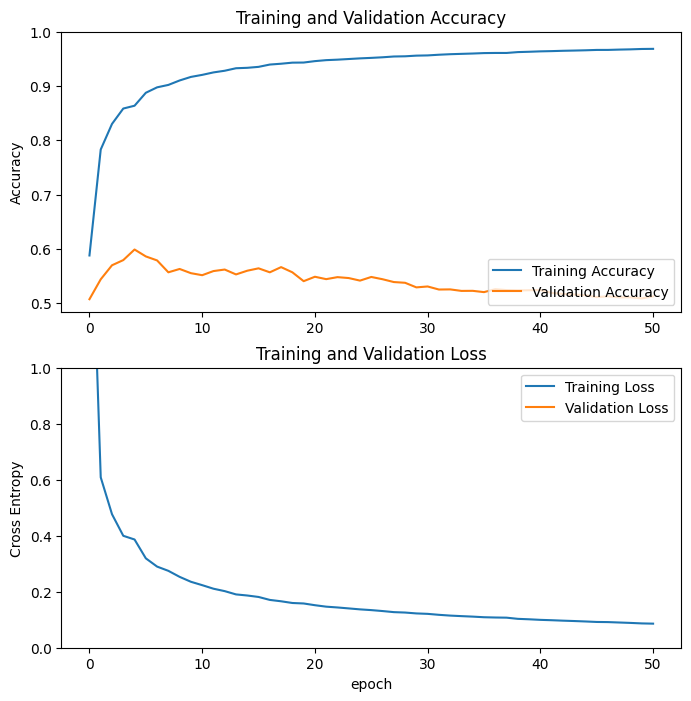

highest validation accuracy 59.87
with train accuracy 86.36
on epoch 5


In [34]:
man_train.show_results(spectral_conv_trainer)

## Pixel Classification Evaluation

In [35]:
def get_gt_and_predicted_labels(dataset, model):
    gt_labels = []
    predicted_labels = []
    for px_batch, label_batch in dataset:
        gt_labels.append(label_batch)
        predictions = model.predict(px_batch, verbose=0)
        #print(predictions.shape)
        pl = tf.argmax(predictions, axis=1)
        #print(pl.shape)
        predicted_labels.append(pl)
    
    print(len(gt_labels), len(predicted_labels))
    gt_labels = tf.concat(gt_labels, axis=0)
    gt_labels = tf.reshape(gt_labels, [-1])
    
    predicted_labels = tf.concat(predicted_labels, axis=0)
    predicted_labels = tf.reshape(predicted_labels, [-1])
    
    return gt_labels, predicted_labels

In [36]:
def get_classification_report(gt_labels, predicted_labels, as_dict=False, label_names = used_labels_written):
       
    if not as_dict:
        cr = classification_report(gt_labels, predicted_labels,\
                            target_names=[label_names[i] for i in set(gt_labels.numpy())])
        print(cr)
        return
    else:
        cr = classification_report(gt_labels, predicted_labels, output_dict=True,\
                            target_names=[labels_names[i] for i in set(gt_labels.numpy())])
        return cr

In [37]:
def print_confusion_matrix(gt_labels, predicted_labels):
    fig, ax = plt.subplots(figsize=(10,10))
    cm = ConfusionMatrixDisplay.from_predictions(gt_labels, predicted_labels, ax=ax,
        display_labels=['plasitc', 'paper', 'wood', 'metal', 'textiles', 'minerals'])
    plt.show()

In [38]:
COLURS=[(0, 0, 0), (112, 75, 215), (170, 162, 161), (233, 239, 227), (0, 59, 53), (176, 181, 250),\
       (230, 14, 60), (51, 24, 19), (203, 169, 1), (111, 242, 121), (251, 79, 33)]

In [39]:
def colorize_mask(mask):
    if tf.rank(mask) == 2:
        mask = tf.expand_dims(mask, axis=-1)
    mask = tf.image.grayscale_to_rgb(
        mask
    ).numpy()
    

    for x in range(len(mask)):
        for y in range(len(mask[x])):
            for c, index in zip(mask[x,y], range(3)):
                mask[x,y,index] = COLURS[c][index]
    return mask
        

In [40]:
def print_color_labels():
    f, axarr = plt.subplots(1, 8, figsize=(10, 1.5))
    for color, index in zip(COLURS, range(8)):
        axarr[index].set_facecolor([c / 255. for c in color])
        axarr[index].set_yticks([])
        axarr[index].set_xticks([])
        axarr[index].set_title((["bg"] + used_labels_written)[index])

    plt.show()


In [41]:
@tf.function
def get_index(px):
    return tf.squeeze(tf.cast(tf.where(tf.equal(px, used_labels)), dtype=tf.uint8))[:,-1]

def get_index_with_bg(px):
    return tf.squeeze(tf.cast(tf.where(tf.equal(px, [0] + used_labels)), dtype=tf.uint8))[:,-1]



def visual_eval(scene_dir, model):
    print ("########################### detailed results for ###################################")
    print("####", scene_dir, "###")
    scene_dir = pathlib.Path(scene_dir)
    channel_paths, mask_path = sort_channel_paths([str(p) for p in scene_dir.glob('registered_scene/*/*.png')])
    msi_as_list_of_tensors = list(map(imgpath_to_tensor, channel_paths))
    msi_as_tensor =  tf.concat(msi_as_list_of_tensors, axis=-1)

    img_patches = tf.reshape(msi_as_tensor, [-1, 14])

    mask_as_tensor = imgpath_to_tensor(mask_path, channels=1)
    mask_patches = tf.reshape(mask_as_tensor, [-1,1])
    
    preds = model.predict(img_patches, batch_size=img_patches.shape[0] // 16)
    preds = tf.argmax(preds, axis=1)
    
    indices = tf.where(tf.not_equal(tf.squeeze(mask_patches), tf.constant(0, dtype=tf.uint8)))
    
    filtered_labels = tf.squeeze(tf.gather(mask_patches, indices=indices),axis=1)
    filtered_preds = tf.squeeze(tf.gather(preds, indices=indices))

    filtered_labels = get_index(filtered_labels)
    
    cr = classification_report(filtered_labels, filtered_preds, 
                               target_names=[used_labels_written[i] for i in set(filtered_preds.numpy())],
                               zero_division=0)
    print(cr)
    
    idx_mask = tf.reshape(get_index_with_bg(tf.reshape(mask_as_tensor,[-1,1])), mask_as_tensor.shape)
    col_gt_mask = colorize_mask(idx_mask)
    plt.figure(figsize=(8, 8))
    plt.imshow(col_gt_mask)
    plt.axis("off")
    plt.show()
    
    
    pred_mask = tf.reshape(preds, mask_as_tensor.shape)
    col_pred_mask = colorize_mask(pred_mask +1 ) #background isn't predicted
    plt.figure(figsize=(8, 8))
    plt.imshow(col_pred_mask)
    plt.axis("off")
    plt.show()

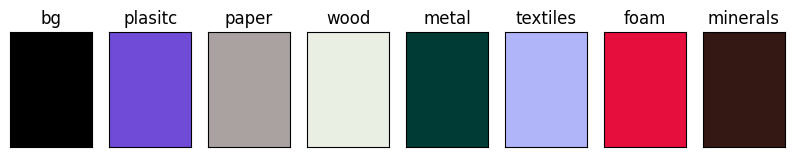

########################### detailed results for ###################################
#### ../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_14_04_06 ###
17/17 [==============================] - 0s 19ms/step
              precision    recall  f1-score   support

     plasitc       0.31      0.09      0.14    117995
       paper       0.66      0.73      0.69    133762
        wood       0.31      0.42      0.36     90306
       metal       0.59      0.58      0.58     65621
    textiles       0.00      0.00      0.00         0
    minerals       0.38      0.88      0.53     19782

    accuracy                           0.47    427466
   macro avg       0.37      0.45      0.38    427466
weighted avg       0.47      0.47      0.45    427466



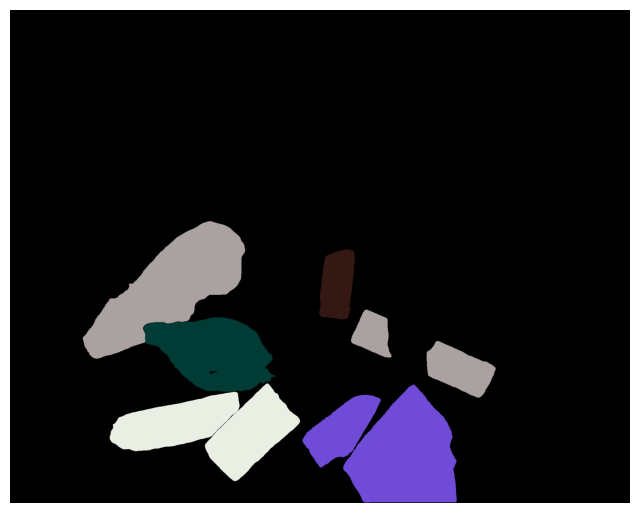

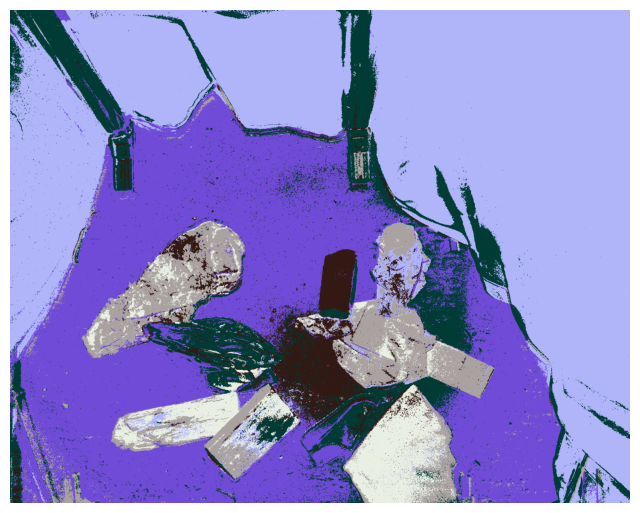

########################### detailed results for ###################################
#### ../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_14_24_11 ###
17/17 [==============================] - 0s 19ms/step
              precision    recall  f1-score   support

     plasitc       0.77      0.81      0.79     91838
       paper       0.63      0.58      0.60     48290
        wood       0.95      0.98      0.97     72829
       metal       0.57      0.44      0.50     38245
    textiles       0.00      0.00      0.00         0
    minerals       0.83      0.83      0.83     75345

    accuracy                           0.77    326547
   macro avg       0.63      0.61      0.61    326547
weighted avg       0.78      0.77      0.78    326547



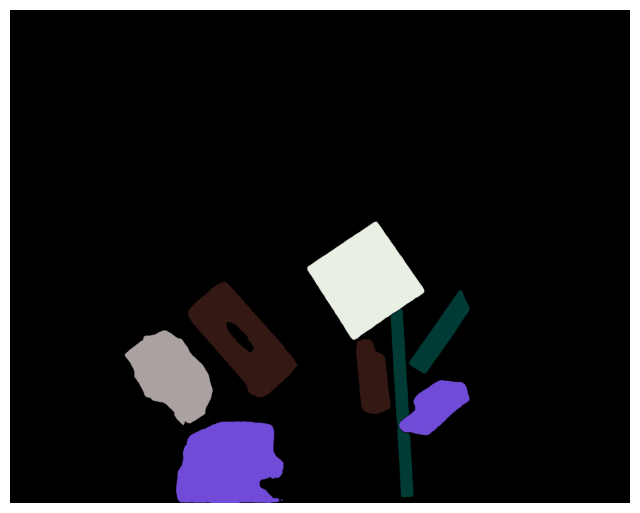

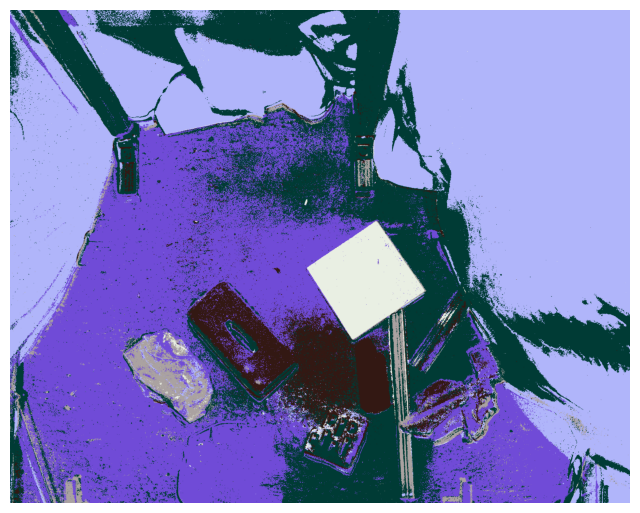

########################### detailed results for ###################################
#### ../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_17_21_44 ###
17/17 [==============================] - 0s 19ms/step
              precision    recall  f1-score   support

     plasitc       0.75      0.31      0.44     64683
       paper       0.51      0.83      0.63     31720
        wood       0.46      0.56      0.50     77209
       metal       0.27      0.86      0.41     12120
    textiles       0.81      0.36      0.50     74411
    minerals       0.00      0.00      0.00         0

    accuracy                           0.49    260143
   macro avg       0.47      0.49      0.41    260143
weighted avg       0.63      0.49      0.50    260143



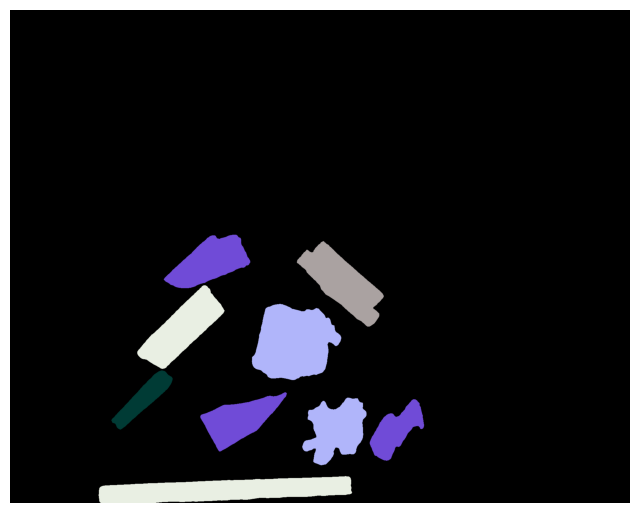

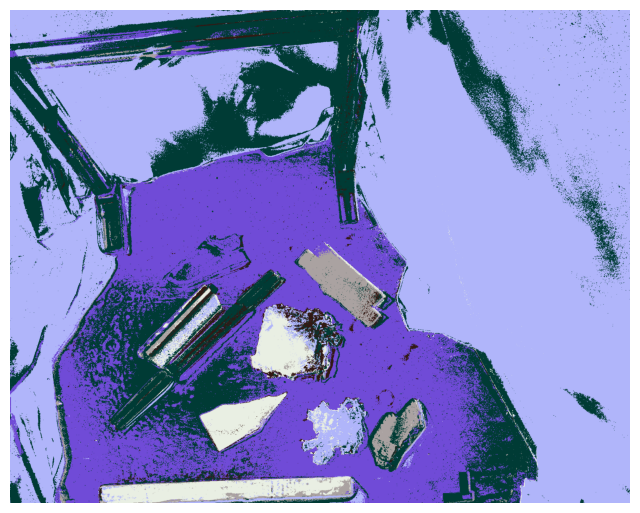

In [42]:
# evalute best spectral conv
best_model =  create_mlp()
best_model.load_weights('models/mlp_msi_v5_darkroom')
print_color_labels()
for val_scene in val_msiv5_darkroom:
    visual_eval(val_scene, best_model)

In [43]:
gt_labels, pred_labels = get_gt_and_predicted_labels(man_train.datasets[0][1], best_model)

31 31


In [44]:
get_classification_report(gt_labels, pred_labels)

              precision    recall  f1-score   support

     plasitc       0.67      0.38      0.49    274516
       paper       0.62      0.71      0.66    213772
        wood       0.53      0.63      0.58    240344
       metal       0.49      0.56      0.53    115986
    textiles       0.50      0.36      0.42     74411
    minerals       0.58      0.84      0.69     95127

    accuracy                           0.57   1014156
   macro avg       0.57      0.58      0.56   1014156
weighted avg       0.58      0.57      0.56   1014156



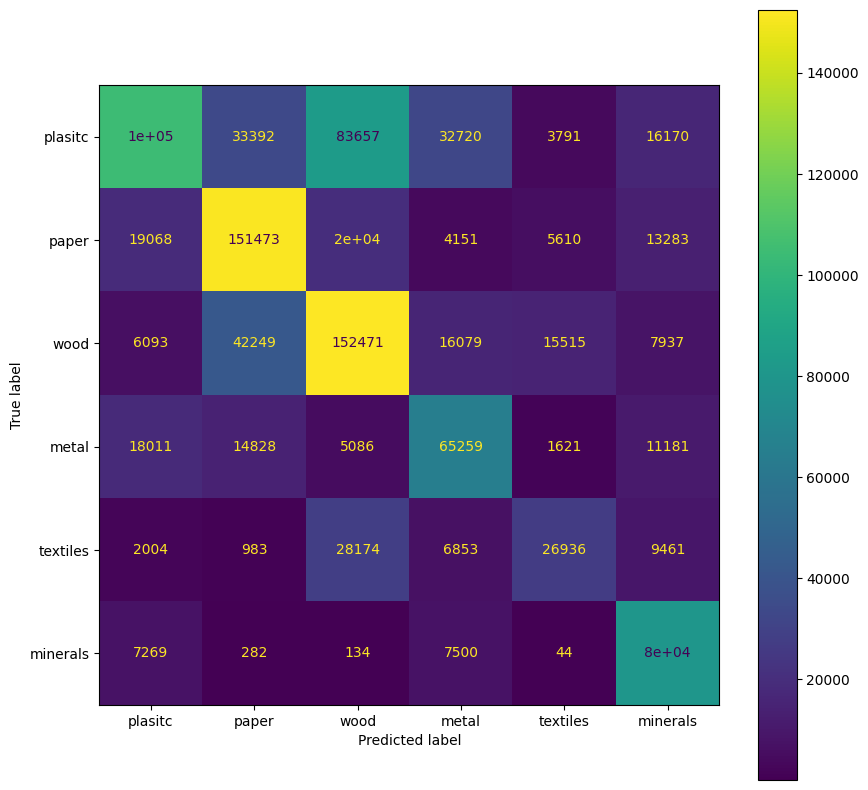

In [45]:
print_confusion_matrix(gt_labels, pred_labels)

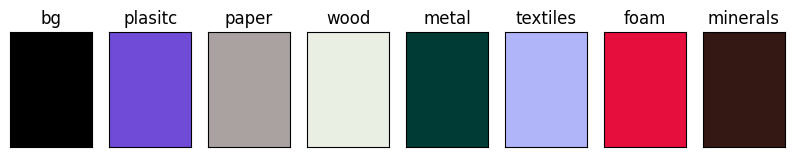

########################### detailed results for ###################################
#### ../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_14_04_06 ###
17/17 [==============================] - 3s 177ms/step
              precision    recall  f1-score   support

     plasitc       0.29      0.10      0.15    117995
       paper       0.77      0.73      0.75    133762
        wood       0.42      0.70      0.52     90306
       metal       0.65      0.59      0.62     65621
    textiles       0.00      0.00      0.00         0
    minerals       0.39      0.84      0.53     19782

    accuracy                           0.53    427466
   macro avg       0.42      0.49      0.43    427466
weighted avg       0.53      0.53      0.51    427466



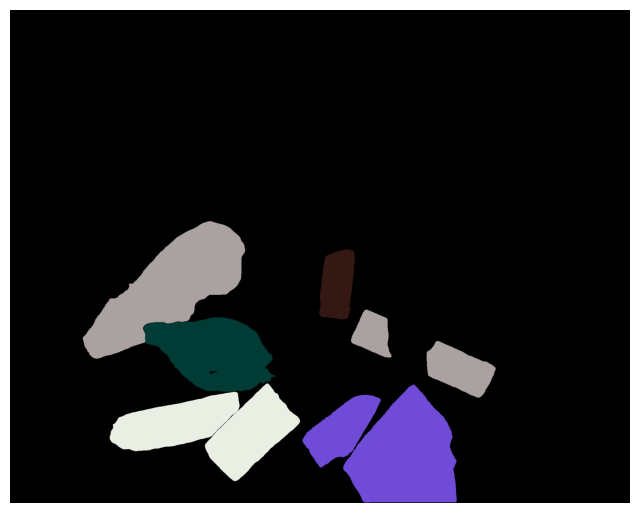

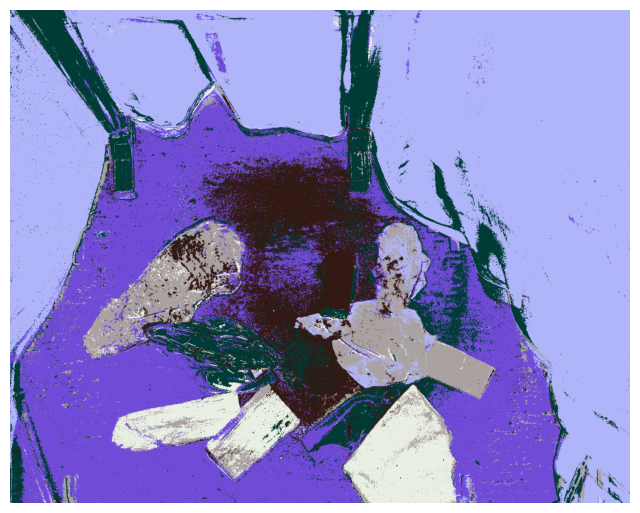

########################### detailed results for ###################################
#### ../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_14_24_11 ###
17/17 [==============================] - 3s 183ms/step
              precision    recall  f1-score   support

     plasitc       0.59      0.83      0.69     91838
       paper       0.12      0.03      0.04     48290
        wood       0.91      0.85      0.88     72829
       metal       0.55      0.62      0.58     38245
    textiles       0.00      0.00      0.00         0
    minerals       0.95      0.88      0.91     75345

    accuracy                           0.70    326547
   macro avg       0.52      0.54      0.52    326547
weighted avg       0.67      0.70      0.68    326547



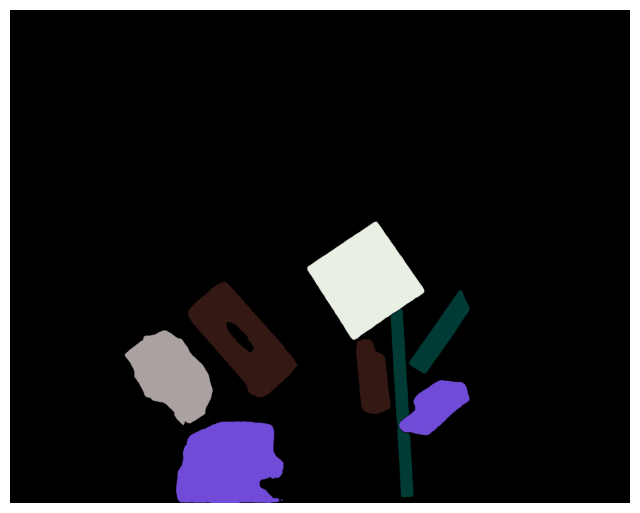

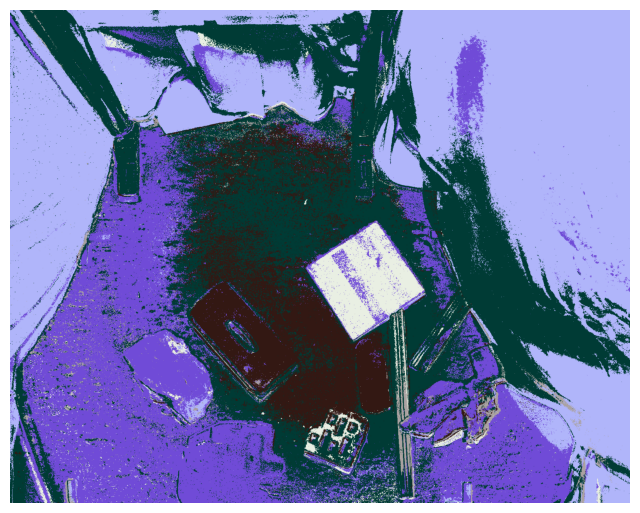

########################### detailed results for ###################################
#### ../datasets/MSIv5/UV_VIS_SWIR/24_03_14_darkroom/recording/24_03_14_17_21_44 ###
17/17 [==============================] - 3s 183ms/step
              precision    recall  f1-score   support

     plasitc       0.48      0.24      0.32     64683
       paper       0.24      0.33      0.28     31720
        wood       0.66      0.45      0.53     77209
       metal       0.20      0.86      0.33     12120
    textiles       0.82      0.71      0.76     74411
    minerals       0.00      0.00      0.00         0

    accuracy                           0.48    260143
   macro avg       0.40      0.43      0.37    260143
weighted avg       0.59      0.48      0.50    260143



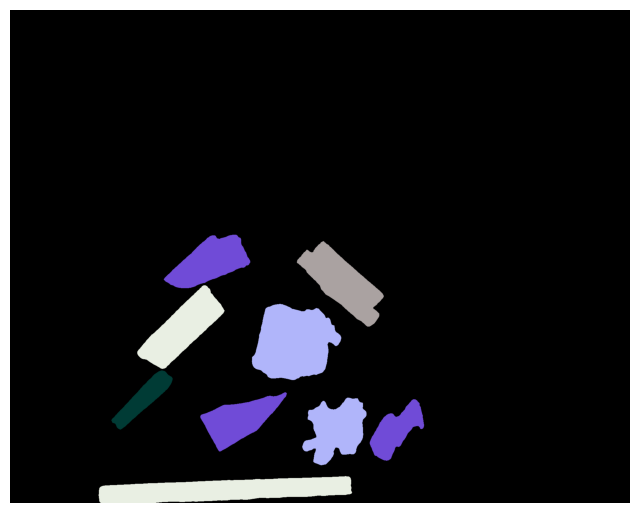

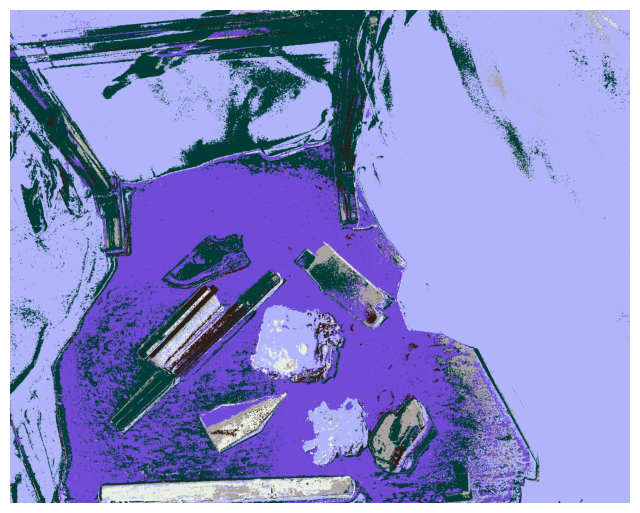

In [46]:
# evalute spectral_con
best_model = create_spectral_conv()
best_model.load_weights('models/spectral_conv_msi_v5_darkroom')
print_color_labels()
for val_scene in val_msiv5_darkroom:
    visual_eval(val_scene, best_model)

In [47]:
gt_labels, pred_labels = get_gt_and_predicted_labels(man_train.datasets[0][1], best_model)

31 31


In [48]:
get_classification_report(gt_labels, pred_labels)

              precision    recall  f1-score   support

     plasitc       0.51      0.38      0.43    274516
       paper       0.60      0.51      0.55    213772
        wood       0.59      0.67      0.63    240344
       metal       0.47      0.63      0.54    115986
    textiles       0.73      0.71      0.72     74411
    minerals       0.64      0.87      0.74     95127

    accuracy                           0.57   1014156
   macro avg       0.59      0.63      0.60   1014156
weighted avg       0.57      0.57      0.57   1014156



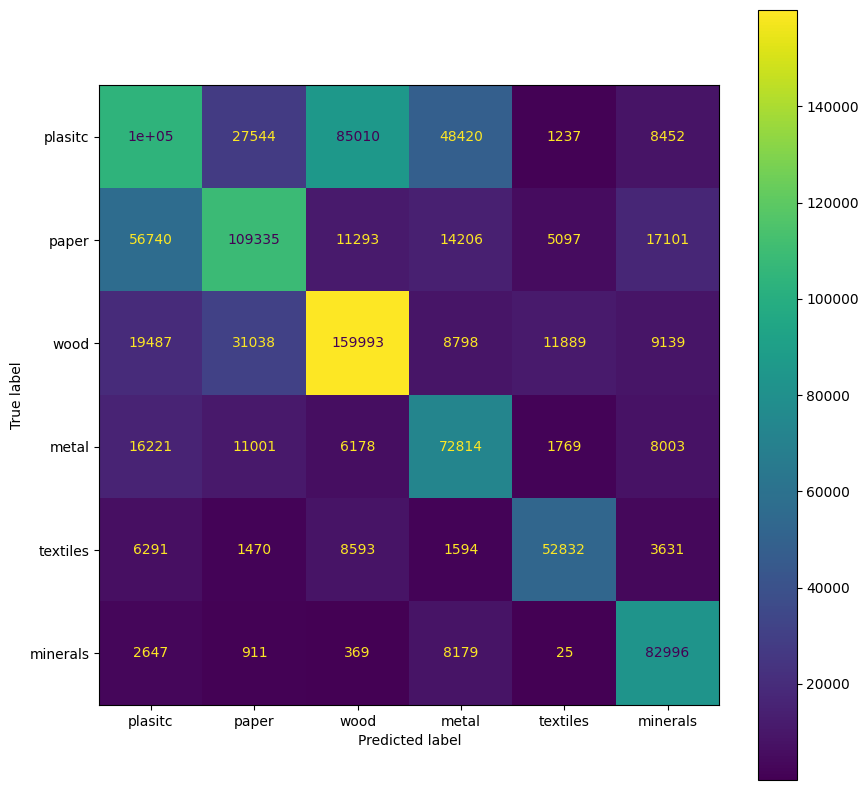

In [49]:
print_confusion_matrix(gt_labels, pred_labels)